# Import & Configuration

In [93]:
from __future__ import annotations

import math, random
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Tuple, Optional
from tqdm import tqdm
from numpy.ma.extras import average

# Configuration

In [94]:
# SIMULATION
simulations_amount = 1
N = 11
steps_amount = 50000
verbose = False

# SCHEDULING
schedule_type = "exp"
T0 = 3.0
T_Min = 0.2

# PLOTTING
collect_data = True
temperature_data = []
energy_data = []

# State

In [95]:
Coord = Tuple[int, int, int]

@dataclass
class State:
    """
    A configuration of N^2 queens on an N x N x N board.

    Attributes
    ----------
    N : int
        Board size (each coordinate in {1, ..., N}).
    queens : List[Coord]
        List of queen positions (distinct coordinates).
    """
    N: int
    queens: List[Coord]
    empties: List[Coord]


# ---------- Board utilities ----------

def generate_all_cells(N: int) -> List[Coord]:
    """
    Generate all coordinates of an N x N x N board.
    """
    return [(x, y, z)
            for x in range(1, N + 1)
            for y in range(1, N + 1)
            for z in range(1, N + 1)]


# We'll reuse this per board size to avoid recomputing every time.
_ALL_CELLS_CACHE = {}

def get_all_cells_cached(N: int) -> List[Coord]:
    if N not in _ALL_CELLS_CACHE:
        _ALL_CELLS_CACHE[N] = generate_all_cells(N)
    return _ALL_CELLS_CACHE[N]


# ---------- State initialization ----------

def generate_initial_state(N: int,
                           rng: Optional[random.Random] = None) -> State:
    """
    Create a random initial state with N^2 queens on distinct cells.

    Parameters
    ----------
    N : int
        Board size.
    rng : random.Random, optional
        RNG for reproducibility. If None, uses global random.

    Returns
    -------
    State
        Random configuration of N^2 queens.
    """
    if rng is None:
        rng = random

    cells = get_all_cells_cached(N)[:]
    rng.shuffle(cells)

    num_queens = N * N
    queens = cells[:num_queens]
    empties = cells[num_queens:]
    return State(N=N, queens=queens, empties=empties)


# ---------- Attack relation and energy ----------

def are_queens_attacking(q1: Coord, q2: Coord) -> bool:
    """
    Check whether two queens attack each other in 3D.

    A queen at (x,y,z) attacks any other square that:
      - shares two coordinates (same x and y or x and z or y and z), or
      - lies on a 2D diagonal in one of the coordinate planes:
            - xy-plane: same z and |dx| = |dy|
            - xz-plane: same y and |dx| = |dz|
            - yz-plane: same x and |dy| = |dz|
      - lies on a 3D diagonal: |dx| = |dy| = |dz|.
    """
    x1, y1, z1 = q1
    x2, y2, z2 = q2

    dx = abs(x1 - x2)
    dy = abs(y1 - y2)
    dz = abs(z1 - z2)

    # Same coordinate (axis-aligned lines)
    if x1 == x2 and y1 == y2 or x1 == x2 and z1 == z2 or y1 == y2 and z1 == z2:
        return True

    # 3D diagonal
    if dx == dy == dz and dx != 0:
        return True

    # 2D diagonals in coordinate planes
    # xy-plane diagonal: same z, |dx| = |dy|
    if z1 == z2 and dx == dy and dx != 0:
        return True

    # xz-plane diagonal: same y, |dx| = |dz|
    if y1 == y2 and dx == dz and dx != 0:
        return True

    # yz-plane diagonal: same x, |dy| = |dz|
    if x1 == x2 and dy == dz and dy != 0:
        return True

    return False

def compute_conflicts(state: State) -> List[int]:
    """
    Compute the number of conflicts for each queen in the current state.

    Parameters
    ----------
    state : State
        Current configuration.

    Returns
    -------
    List[int]
        conflicts[i] = number of other queens that attack queens[i].
    """
    Q = state.queens
    n = len(Q)
    conflicts = [0] * n
    for i in range(n):
        for j in range(i + 1, n):
            if are_queens_attacking(Q[i], Q[j]):
                conflicts[i] += 1
                conflicts[j] += 1
    return conflicts


def compute_energy(state: State) -> int:
    """
    Compute the energy H(X) = number of attacking queen pairs.

    Parameters
    ----------
    state : State
        Current configuration.

    Returns
    -------
    int
        Number of unordered pairs (i,j) of queens that attack each other.
    """
    H = 0
    Q = state.queens
    n = len(Q)
    for i in range(n):
        for j in range(i + 1, n):
            if are_queens_attacking(Q[i], Q[j]):
                H += 1
    return H


# Scheduling

In [96]:
def schedule_linear(t):
    return T0 - (T0 - T_Min) * (t / steps_amount)

def schedule_exp(t):
    r = (T_Min / T0) ** (1.0 / steps_amount)
    return T0 * (r ** t)

def schedule_power(t, tau=2_000, alpha=0.7):
    return T0 / ((1.0 + t / tau) ** alpha)

def schedule_two_phase(t, frac_warmup=0.3):
    warmup_steps = int(frac_warmup * steps_amount)
    if t < warmup_steps:
        return T0
    # Exponential from T0 to Tmin over the remaining steps
    remaining = steps_amount - warmup_steps
    k = t - warmup_steps
    r = (T_Min / T0) ** (1.0 / remaining)
    return T0 * (r ** k)

def temperature_schedule(t):
    if schedule_type == "linear":
        return schedule_linear(t)
    elif schedule_type == "exp":
        return schedule_exp(t)
    elif schedule_type == "power":
        return schedule_power(t, tau=5_000, alpha=0.7)
    elif schedule_type == "two_phase":
        return schedule_two_phase(t, frac_warmup=0.3)
    else:
        raise ValueError("Unknown schedule")

# Simulation

In [97]:
def propose(state: State,
            eps: float = 1.0,
            rng: Optional[random.Random] = None):
    """
    Propose a move:
      - pick a queen with probability proportional to (conflicts + eps),
      - pick an empty cell uniformly,
      - move the chosen queen there.

    Parameters
    ----------
    state : State
        Current configuration X.
    eps : float
        Small positive constant to ensure all queens have nonzero weight.
    rng : random.Random, optional
        RNG for reproducibility.

    Returns
    -------
    proposal_state : State
        Proposed new state Y.
    i_q : int
        Index of the moved queen in the original state's queen list.
    old_pos : Coord
        Old position of that queen in X.
    new_pos : Coord
        New position of that queen in Y (an empty cell in X).
    conflicts_X : List[int]
        Conflict counts in X (for proposal ratio).
    Z_Q_X : float
        Sum of weights w_i = conflicts_X[i] + eps in X.
    """
    if rng is None:
        rng = random

    N = state.N
    queens = state.queens[:]
    empties = state.empties[:]
    conflicts_X = compute_conflicts(state)

    # weights w_i = conflicts_i + eps
    weights = [c + eps for c in conflicts_X]
    Z_Q_X = sum(weights)

    # choose queen index with probability proportional to weights
    r = rng.random() * Z_Q_X
    cumulative = 0.0
    i_q = 0
    for idx, w in enumerate(weights):
        cumulative += w
        if r <= cumulative:
            i_q = idx
            break

    old_pos = queens[i_q]

    # choose random empty
    i_e = rng.randrange(len(empties))
    new_pos = empties[i_e]

    # move queen
    queens[i_q] = new_pos
    proposal_state = State(N=N, queens=queens, empties=empties)

    return proposal_state, i_q, old_pos, new_pos, conflicts_X, Z_Q_X

# ---------- Metropolis / simulated annealing ----------

def metropolis_step(state: State,
                    T: float,
                    eps: float = 1.0,
                    rng: Optional[random.Random] = None,
                    stats = None) -> State:
    """
    One Metropolis-Hastings step with conflict-biased proposal.

    Proposal Q(X,·):
      - choose queen i with prob ~ conflicts_i(X) + eps,
      - choose empty uniformly,
      - move queen i there.

    Acceptance probability:
      alpha = min(1,
                  exp(-ΔH / T) * [Q(Y->X) / Q(X->Y)] )

    Parameters
    ----------
    state : State
        Current state X.
    T : float
        Temperature.
    eps : float
        Small positive constant added to conflicts to ensure all queens
        have nonzero weight.
    rng : random.Random, optional
        RNG.

    Returns
    -------
    State
        New state (either accepted proposal Y or original X).
    """
    if rng is None:
        rng = random

    current_E = compute_energy(state)

    # Propose Y and get information about Q(X->Y)
    (proposal,
     i_q,
     old_pos,
     new_pos,
     conflicts_X,
     Z_Q_X) = propose(state, eps=eps, rng=rng)

    proposal_E = compute_energy(proposal)
    dH = proposal_E - current_E

    # Compute data for Q(Y->X)
    conflicts_Y = compute_conflicts(proposal)
    queens_Y = proposal.queens

    # In Y, the queen we moved is at new_pos; find its index
    idx_back = queens_Y.index(new_pos)

    w_i_X = conflicts_X[i_q] + eps
    w_k_Y = conflicts_Y[idx_back] + eps
    Z_Q_Y = sum(c + eps for c in conflicts_Y)

    # |empties| cancels in the ratio, so:
    # Q(Y->X) / Q(X->Y) = [w_k(Y)/Z_Q(Y)] / [w_i(X)/Z_Q(X)]
    q_ratio = (w_k_Y * Z_Q_X) / (w_i_X * Z_Q_Y)

    if T <= 0:
        # Degenerate case: purely greedy with Hastings correction
        accept_prob = 1.0 if (dH < 0 and q_ratio >= 1.0) else 0.0
    else:
        accept_prob = min(1.0, math.exp(-dH / T) * q_ratio)

    if rng.random() < accept_prob:
        if stats is not None:
            stats["accepted"] += 1
        return proposal
    else:
        return state


def run_annealing(eps: float = 1.0,
                  rng: Optional[random.Random] = None) -> (State, int):
    """
    Run simulated annealing using conflict-biased Metropolis-Hastings.

    Parameters
    ----------
    eps : float
        Small positive constant for conflict weights.
    rng : random.Random, optional
        RNG.

    Returns
    -------
    State
        Best state found (lowest energy observed).
    """
    if rng is None:
        rng = random.Random()

    # State tracking variables
    current_state = generate_initial_state(N, rng)
    best_state = current_state
    best_energy = compute_energy(current_state)
    
    # Data collection
    temperature_data.clear()
    energy_data.clear()

    if verbose:
        print(f"Initial energy: {best_energy}")
        
    stats = {"accepted": 0}

    for t in tqdm(range(steps_amount), desc=f"Progress: ", colour="white"):
        current_temperature = temperature_schedule(t)
        current_state = metropolis_step(current_state, current_temperature, eps=eps, rng=rng, stats=stats)

        current_energy = compute_energy(current_state)
        
        if collect_data:
            temperature_data.append(current_temperature)
            energy_data.append(current_energy)

        if current_energy < best_energy:
            best_energy = current_energy
            best_state = current_state
            if verbose:
                print(f"[step {t}] New best energy: {best_energy}")
            if best_energy == 0:
                if verbose:
                    print(f"Found solution (energy 0) at step {t}")
                break

    if verbose:
        print(f"Finished after {t+1} steps. Best energy: {best_energy}")
        
    print("Acceptance rate:", stats["accepted"] / steps_amount)

    return best_state, best_energy

# Project

In [98]:
if __name__ == "__main__":
    results = []

    print(f"\nRunning {simulations_amount} simulations with N = {N}, Steps = {steps_amount}, Starting"
          f" Temperature = {T0} and Temperature Scheduling = {schedule_type}\n")

    # Executing simulations
    for i in range (simulations_amount):
        print(f"Starting simulation {i + 1} of {simulations_amount}")

        state, energy = run_annealing()

        print(f"Iteration {i + 1}, best energy {energy}\n")
        results.append(energy)

    print(f"Final averaged best energy: {average(results)}")


Running 1 simulations with N = 11, Steps = 50000, Starting Temperature = 3.0 and Temperature Scheduling = exp

Starting simulation 1 of 1


Progress: 100%|██████████| 50000/50000 [12:03<00:00, 69.10it/s]

Acceptance rate: 0.22826
Iteration 1, best energy 53

Final averaged best energy: 53.0


# Plots

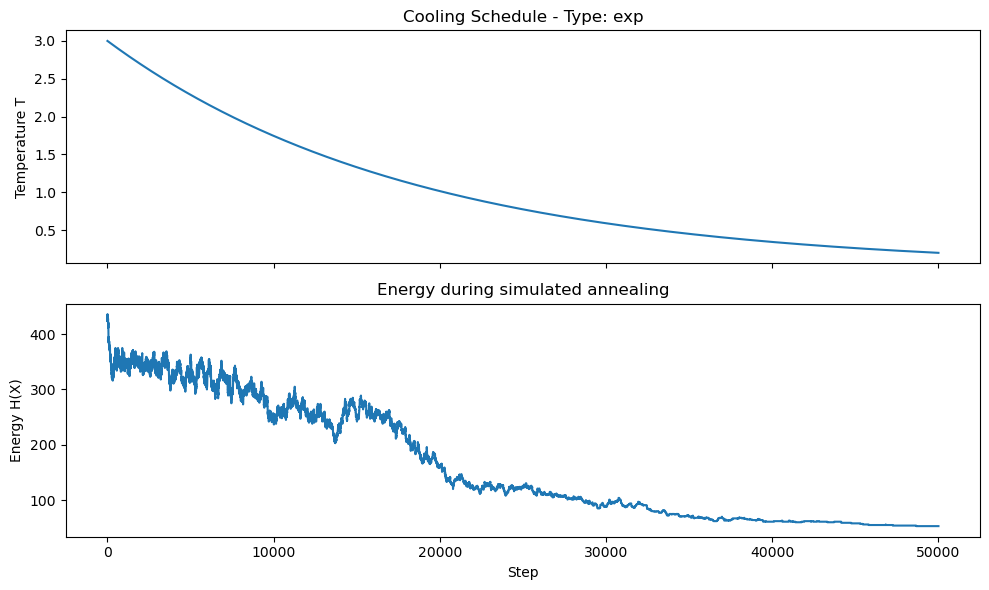

In [99]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

steps = range(len(temperature_data))

# Temperature vs step
ax1.plot(steps, temperature_data)
ax1.set_ylabel("Temperature T")
ax1.set_title(f"Cooling Schedule - Type: {schedule_type}")

# Energy vs step
ax2.plot(steps, energy_data)
ax2.set_xlabel("Step")
ax2.set_ylabel("Energy H(X)")
ax2.set_title("Energy during simulated annealing")

plt.tight_layout()
plt.show()